## Importing modules

In [8]:
##ConvLSTM
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as k
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from numpy import float32
from dataset_64 import ClimateHackDataset
import torch.optim as optim
from torch.utils.data import DataLoader
import torch as pt
import torchvision as tv

#from functools import partial

In [9]:
######DO NOT TOUCH############
class DataGenerator(k.utils.Sequence):
    def __init__(self, gen, ncl):
        self.gen = gen
        self.iter = iter(gen)
        self.ncl = ncl

    def __getitem__(self, _):
        try:
            coordinates, features, labels = next(self.iter)
        except StopIteration:
            self.iter = iter(self.gen)
            coordinates, features, labels = next(self.iter)
        #tensor is (batch_size, chann, H, W); convert to (batch, H, W, chann)
        features = features.permute(0, 2, 3, 1).numpy()
        labels = labels.permute(0, 2, 3, 1).numpy()
    #Input must be (batch_size, frame_num, H, W, channels)
        features = np.expand_dims(features, 0) 
        Images = features[0, :, :, :, :]
        X = tf.image.resize_with_crop_or_pad(Images, 64, 64)
        features = np.expand_dims(X, 1) 
        ######DO NOT TOUCH############
        labels = np.expand_dims(labels, 0) 
        labels = labels[0, :, :, :, :]
        labels = np.expand_dims(labels, 1) 
        #Expanding dimensions (frame number)
        #X = X/1023
        
        return features, labels

    def __len__(self):
        return 1000 #len(list(self.gen))

In [3]:
# import tensorflow_addons as tfa

# def Ranger(sync_period=6,
#            slow_step_size=0.5,
#            learning_rate=0.001,
#            beta_1=0.95,
#            beta_2=0.999,
#            epsilon=1e-7,
#            weight_decay=0.,
#            amsgrad=False,
#            sma_threshold=5.0,
#            total_steps=0,
#            warmup_proportion=0.1,
#            min_lr=0.0001,
#            name="Ranger"):
#     inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
#     optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
#     return optim

In [23]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
aiohttp                      3.8.1
aiosignal                    1.2.0
antialiased-cnns             0.3
anyio                        3.5.0
argon2-cffi                  20.1.0
arrow                        1.2.2
asciitree                    0.3.3
astor                        0.8.1
astunparse                   1.6.3
async-generator              1.10
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.9.1
backcall                     0.2.0
bleach                       4.1.0
blinker                      1.4
blis                         0.7.5
bng-latlon                   1.0.3
bokeh                        2.4.2
Bottleneck                   1.3.2
brotlipy                     0.7.0
cachetools                   4.2.4
Cartopy                      0.18.0
catalogue                    2.0.6
certifi                      2021.10.8
cf

You should consider upgrading via the 'C:\Users\james\anaconda3\envs\climatehack\python.exe -m pip install --upgrade pip' command.



fasteners                    0.17.3
fastprogress                 1.0.2
filelock                     3.4.2
Flask                        2.0.2
flatbuffers                  2.0
fonttools                    4.25.0
frozenlist                   1.3.0
fsspec                       2022.1.0
future                       0.18.2
gast                         0.5.3
gcsfs                        2022.1.0
geos                         0.2.3
google-api-core              2.4.0
google-auth                  2.6.0
google-auth-oauthlib         0.4.6
google-cloud-core            2.2.2
google-cloud-storage         2.0.0
google-crc32c                1.1.2
google-pasta                 0.2.0
google-resumable-media       2.1.0
googleapis-common-protos     1.54.0
grpcio                       1.42.0
h5py                         3.6.0
HeapDict                     1.0.1
huggingface-hub              0.4.0
idna                         3.3
importlib-metadata           4.8.2
ipykernel                    6.4.1
ipython     

In [3]:
# SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr"
SATELLITE_ZARR_PATH = "eumetsat_seviri_hrv_uk.zarr"
dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks={},  # Load the data as a Dask array
)

In [10]:
BATCH_SIZE = 8
EPOCHS = 8

ch_dataset = ClimateHackDataset(dataset, crops_per_slice=2)
ch_dataloader = DataLoader(ch_dataset, batch_size=BATCH_SIZE)
dataloader = DataGenerator(ch_dataloader, 2) # ncl represents the number of classes for the model

In [11]:
def msssim_loss(y_true, y_pred):
    msssim= 1-tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1023, power_factors=(0.0448, 0.2856, 0.3001, 0.2363, 0.1333), filter_size=2, filter_sigma=1.5, k1=0.03, k2=0.09))
#     mse= tf.keras.losses.mse(y_true, y_pred) #, 0.1333 is last 2 power filter
#     avgloss= (mse + msssim)/2
    return msssim

In [12]:
# device = "cuda" if pt.cuda.is_available() else "cpu"
# kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

inp = layers.Input(shape=(None, *(64,64,1)))  ##64,64,1 ; 96 96 1

x = layers.ConvLSTM2D(filters=64,
    kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu",)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64,
    kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu",)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64, 
    kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu",)(x)

x = layers.Conv3D(filters=1, 
    kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)*1023
## originally 3,3,3
#try images of 70 x70?


model = keras.models.Model(inp, x)  #inp is input, x is output
#optimizer = Ranger()
model.compile(loss=msssim_loss, optimizer = 'adam')#msssim_loss   tf.keras.losses.mse

In [13]:
model.fit(dataloader, epochs=EPOCHS)
model.save('submission/saved_model/my_model')

Epoch 1/4
1000/1000 [==============================] - 21903s 22s/step - loss: 0.0263
Epoch 2/4
 489/1000 [=============>................] - ETA: 3:19:00 - loss: 0.0256

KeyboardInterrupt: 

In [14]:
model.save('submission/saved_model/my_model')

INFO:tensorflow:Assets written to: submission/saved_model/my_model\assets


In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization_2 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_3 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                           

python doxa_cli.py user login
python doxa_cli.py agent upload climatehack ./submission

Get Iteration

In [16]:
coor, feat, label = next(iter(ch_dataloader))

torch.Size([8, 1, 64, 64])
(8, 64, 64, 1)
(1, 8, 64, 64, 1)
(8, 64, 64, 1)
(8, 1, 64, 64, 1)
[[[125.]
  [120.]
  [114.]
  ...
  [136.]
  [135.]
  [135.]]

 [[116.]
  [109.]
  [ 92.]
  ...
  [134.]
  [134.]
  [132.]]

 [[ 89.]
  [ 84.]
  [ 77.]
  ...
  [134.]
  [134.]
  [128.]]

 ...

 [[124.]
  [117.]
  [114.]
  ...
  [121.]
  [123.]
  [124.]]

 [[120.]
  [116.]
  [109.]
  ...
  [123.]
  [120.]
  [121.]]

 [[116.]
  [110.]
  [100.]
  ...
  [121.]
  [121.]
  [123.]]]


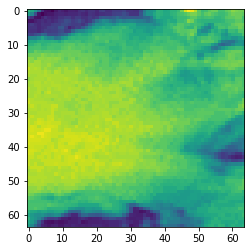

In [17]:
# Loading sample image
print(feat.size())

features = feat.permute(0, 2, 3, 1).numpy()
print(features.shape)
features = np.expand_dims(features, 0) 
print(features.shape)
Images = features[0, :, :, :, :]
print(Images.shape)
# X = tf.image.resize_with_crop_or_pad(Images, 64, 64)
features = np.expand_dims(Images, 1) 

print(features.shape)
print(features[0][0])
plt.imshow(features[0][0])

In [18]:
model = tf.keras.models.load_model('submission/saved_model/my_model', compile=False)

(8, 1, 64, 64, 1)


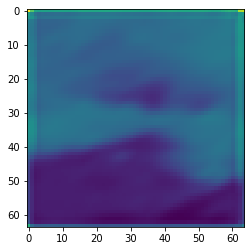

In [21]:
pred = model.predict(features)
print(pred.shape)
# print(pred[0][0])
# pred = np.squeeze(np.squeeze(pred, axis = 0), axis = 0)
plt.imshow(pred[1][0])

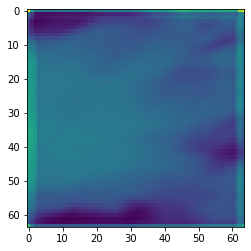

In [20]:
# print(pred[0][0]*1023)
plt.imshow(pred[0][0]*1023)

tensor([[127., 114.,  96.,  ..., 136., 134., 136.],
        [107.,  85.,  74.,  ..., 134., 134., 139.],
        [ 82.,  76.,  78.,  ..., 134., 132., 138.],
        ...,
        [127., 124., 120.,  ..., 132., 131., 131.],
        [124., 120., 113.,  ..., 129., 131., 131.],
        [124., 112., 105.,  ..., 129., 131., 129.]])


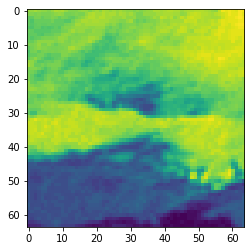

In [22]:
plt.imshow(label[1][0])
print(label[0][0])

## Submitting your model to DOXA

```bash
$ python doxa_cli.py user login
```


```bash
$ python doxa_cli.py agent upload climatehack ./submission
```